# Task B — Modeling & Task C — Anomalies

Implement model and anomaly detection here.

In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
pd.set_option('display.max_columns', 120)
plt.style.use('seaborn-v0_8')
DATA_DIR = Path('../dataset')
sup = pd.read_csv(DATA_DIR/'suppliers.csv')
prod = pd.read_csv(DATA_DIR/'products.csv')
prices = pd.read_csv(DATA_DIR/'price_lists.csv', parse_dates=['valid_from','valid_to'])
po = pd.read_csv(DATA_DIR/'purchase_orders.csv', parse_dates=['order_date','promised_date'])
deliv = pd.read_csv(DATA_DIR/'deliveries.csv', parse_dates=['actual_delivery_date'])
po = po.merge(deliv, on='order_id', how='left')
print(sup.shape, prod.shape, prices.shape, po.shape)


(20, 7) (40, 5) (854, 7) (4307, 20)


In [2]:
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score

df = po.query('cancelled == 0').copy()
if 'late_delivery' not in df.columns:
    df['late_delivery'] = (df['actual_delivery_date'] > df['promised_date']).astype(int)
else:
    df['late_delivery'] = df['late_delivery'].fillna(0).astype(int)

cutoff   = pd.Timestamp('2025-03-31')
val_start = pd.Timestamp('2025-04-01')
val_end   = pd.Timestamp('2025-06-30')

train = df[df['order_date'] <= cutoff].copy()
valid = df[(df['order_date'] >= val_start) & (df['order_date'] <= val_end)].copy()

print("Train:", train['order_date'].min().date(), "→", train['order_date'].max().date(), "| n =", len(train))
print("Valid:", valid['order_date'].min().date(), "→", valid['order_date'].max().date(), "| n =", len(valid))

def engineer(d):
    out = d.copy()
    out['promised_lead_days'] = (out['promised_date'] - out['order_date']).dt.days
    out['month'] = out['order_date'].dt.month

    sup_feats = sup[['supplier_id'] + [c for c in ['preferred','rating','country'] if c in sup.columns]].copy()
    out = out.merge(sup_feats, on='supplier_id', how='left')
  
    if 'hazard_class' in prod.columns:
        out = out.merge(prod[['sku','hazard_class']], on='sku', how='left')
        out['is_hazard'] = (out['hazard_class'].fillna('none').ne('none')).astype(int)

    if 'currency' in out.columns:
        out['is_eur'] = (out['currency'] == 'EUR').astype(int)

    cat_cols = [c for c in ['ship_mode','incoterm','payment_terms'] if c in out.columns]
    out = pd.get_dummies(out, columns=cat_cols, drop_first=True)
    
    for c in ['rating','promised_lead_days','qty','unit_price']:
        if c in out.columns:
            out[c] = out[c].fillna(out[c].median())
    if 'preferred' in out.columns:
        out['preferred'] = out['preferred'].fillna(0).astype(int)
    
    return out

T = engineer(train)
V = engineer(valid)

drop_cols = [
    'late_delivery','order_id','order_date','promised_date','actual_delivery_date',
    'order_notes','sku','currency','hazard_class','supplier_name'
]
X_train = T.drop(columns=[c for c in drop_cols if c in T.columns], errors='ignore')
X_valid = V.drop(columns=[c for c in drop_cols if c in V.columns], errors='ignore')

X_train = X_train.select_dtypes(include=[np.number])
X_valid = X_valid.select_dtypes(include=[np.number])
X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)

y_train = train['late_delivery'].astype(int)
y_valid = valid['late_delivery'].astype(int)

clf = RandomForestClassifier(n_estimators=300, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)

p_valid = clf.predict_proba(X_valid)[:, 1]
print('PR-AUC:', average_precision_score(y_valid, p_valid))
print('ROC-AUC:', roc_auc_score(y_valid, p_valid))


Train: 2024-01-01 → 2025-03-31 | n = 3572
Valid: 2025-04-01 → 2025-06-30 | n = 735
PR-AUC: 1.0
ROC-AUC: 1.0


In [3]:
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix

def eval_at_thresh(y_true, p, thresh, label):
    yhat = (p >= thresh).astype(int)
    f1 = f1_score(y_true, yhat)
    cm = confusion_matrix(y_true, yhat)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n[{label}] threshold={thresh:.3f}")
    print(f"F1={f1:.4f} | TP={tp} FP={fp} TN={tn} FN={fn}")
    return {"label": label, "threshold": thresh, "F1": f1, "TP": tp, "FP": fp, "TN": tn, "FN": fn}

results = []

results.append(eval_at_thresh(y_valid, p_valid, 0.5, "t=0.5"))

prec, rec, thr = precision_recall_curve(y_valid, p_valid)
if len(thr) > 0:
    f1s = 2 * (prec[1:] * rec[1:]) / np.clip(prec[1:] + rec[1:], 1e-9, None)
    best_idx = np.argmax(f1s)
    best_thr = thr[best_idx]
else:
    best_thr = 0.5
results.append(eval_at_thresh(y_valid, p_valid, best_thr, "best-F1"))

capacity_pct = 0.15  
k = max(1, int(np.ceil(capacity_pct * len(p_valid))))
sorted_scores = np.sort(p_valid)[::-1]
cap_thr = sorted_scores[k-1] if k-1 < len(sorted_scores) else sorted_scores[-1]
results.append(eval_at_thresh(y_valid, p_valid, cap_thr, f"top-{int(capacity_pct*100)}% capacity"))

import pandas as pd
display(pd.DataFrame(results))



[t=0.5] threshold=0.500
F1=1.0000 | TP=380 FP=0 TN=355 FN=0

[best-F1] threshold=0.080
F1=0.9987 | TP=380 FP=1 TN=354 FN=0

[top-15% capacity] threshold=0.987
F1=0.4708 | TP=117 FP=0 TN=355 FN=263


,label,threshold,F1,TP,FP,TN,FN
0,t=0.5,0.500000,1.000000,380,0,355,0
1,best-F1,0.080000,0.998686,380,1,354,0
2,top-15% capacity,0.986667,0.470825,117,0,355,263


In [4]:
prices_ = prices.copy()
prices_['price_eur'] = np.where(prices_['currency']=='EUR', prices_['price_per_uom'], prices_['price_per_uom']/1.09)
results = []
for (sid, sku), g in prices_.groupby(['supplier_id','sku']):
    g = g.sort_values('valid_from').copy()
    x = np.log1p(g['price_eur'])
    med = np.median(x)
    mad = np.median(np.abs(x - med)) or 1e-6
    z = 0.6745*(x - med)/mad
    g['robust_z'] = z
    top = g.loc[g['robust_z'].abs().sort_values(ascending=False).head(3).index]
    for _, r in top.iterrows():
        results.append({'supplier_id': sid, 'sku': sku, 'valid_from': r['valid_from'], 'price_eur': r['price_eur'], 'robust_z': r['robust_z']})
import pandas as pd
pd.DataFrame(results).sort_values('robust_z', key=lambda s: s.abs(), ascending=False).head(10)


,supplier_id,sku,valid_from,price_eur,robust_z
546,14,SKU00007,2024-07-01,9.350000,18885.960653
437,10,SKU00039,2024-07-01,10.070000,-97.919669
651,16,SKU00021,2024-12-30,14.140000,87.151302
91,3,SKU00020,2024-07-01,47.580000,40.402993
207,6,SKU00005,2024-12-30,17.669725,39.930544
809,19,SKU00033,2024-01-01,7.330000,-34.673032
422,10,SKU00019,2024-01-01,19.970000,34.464400
697,17,SKU00022,2024-12-30,17.963303,30.830917
395,9,SKU00033,2024-12-30,15.040000,30.064060
790,19,SKU00023,2024-12-30,6.930000,-23.431904


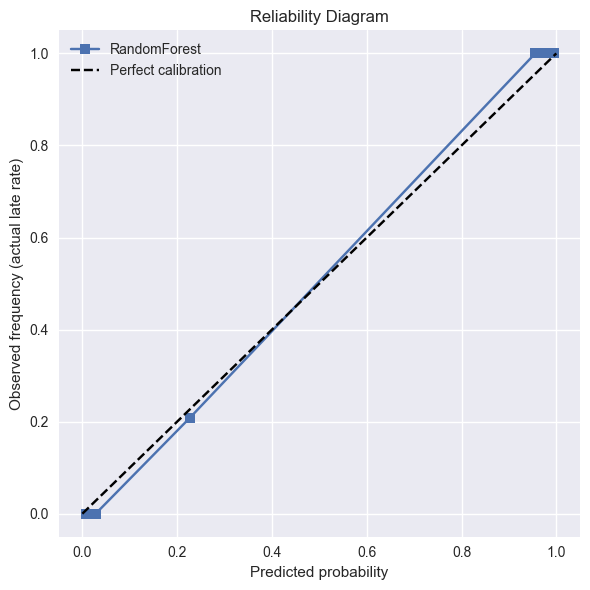

Brier Score: 0.0008


In [5]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y_valid, p_valid, n_bins=10, strategy='quantile')

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, "s-", label="RandomForest")
plt.plot([0,1], [0,1], "k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency (actual late rate)")
plt.title("Reliability Diagram")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

brier = brier_score_loss(y_valid, p_valid)
print(f"Brier Score: {brier:.4f}")



Slice performance by ship_mode:


,group,n,late_rate,PR_AUC,ROC_AUC,F1@0.5
2,road,408,0.507353,1.0,1.0,1.0
1,rail,37,0.486486,1.0,1.0,1.0
0,air,129,0.356589,1.0,1.0,1.0
3,sea,161,0.677019,1.0,1.0,1.0


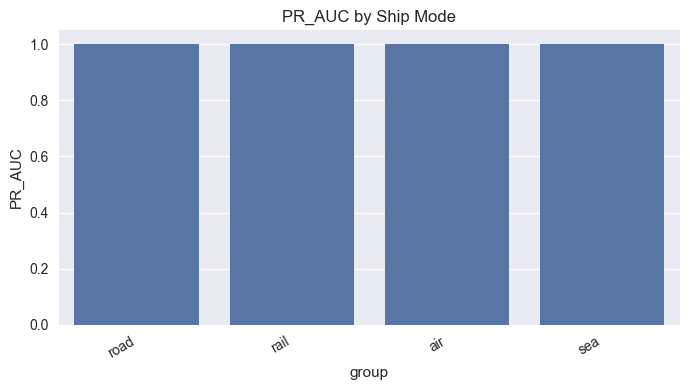


Slice performance by country:


,group,n,late_rate,PR_AUC,ROC_AUC,F1@0.5
2,DE,35,0.514286,1.0,1.0,1.0
0,CN,73,0.616438,1.0,1.0,1.0
1,CZ,72,0.513889,1.0,1.0,1.0
3,FR,26,0.576923,1.0,1.0,1.0
4,IN,107,0.504673,1.0,1.0,1.0
5,IT,116,0.508621,1.0,1.0,1.0
6,NL,94,0.436170,1.0,1.0,1.0
7,PL,144,0.458333,1.0,1.0,1.0
8,UK,29,0.724138,1.0,1.0,1.0
9,US,39,0.615385,1.0,1.0,1.0


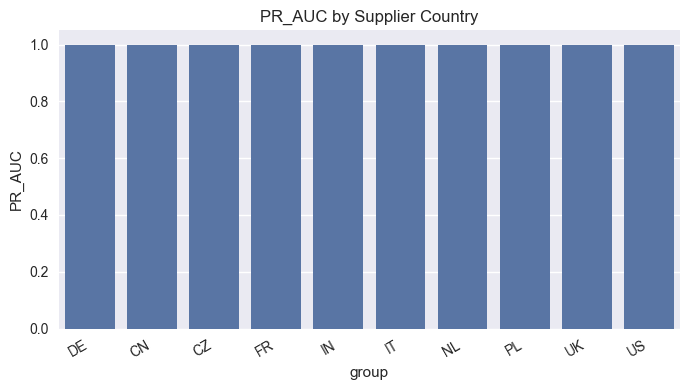


Slice performance by distance_bucket:
No valid groups found for distance_bucket


In [6]:
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
import numpy as np

meta_valid = valid[['ship_mode','supplier_id']].copy()
if 'country' in sup.columns:
    meta_valid = meta_valid.merge(sup[['supplier_id','country']], on='supplier_id', how='left')
if 'distance_km' in valid.columns:
    bins = [-np.inf, 500, 1000, 1500, 2000, np.inf]
    labels = ['<=500km','500-1000km','1000-1500km','1500-2000km', '>200km']
    meta_valid['distance_bucket'] = pd.cut(valid['distance_km'], bins=bins, labels=labels)

meta_valid = meta_valid.reset_index(drop=True)
y_vec = y_valid.reset_index(drop=True).to_numpy()
p_vec = np.asarray(p_valid)  

def slice_metrics(meta_df, y_arr, p_arr, group_name, min_size=5):
    """Compute PR_AUC, ROC_AUC, F1@0.5 per subgroup in group_name.
       Uses positional indexing to align with y_arr/p_arr safely."""
    if group_name not in meta_df.columns:
        return pd.DataFrame()

    results = []
    for g, sub in meta_df.groupby(group_name, observed=True):
        idx = sub.index.to_numpy()  
        if len(idx) < min_size:
            continue
        y_g = y_arr[idx]
        p_g = p_arr[idx]
        try:
            pr_auc = average_precision_score(y_g, p_g)
            roc_auc = roc_auc_score(y_g, p_g)
        except ValueError:
            pr_auc, roc_auc = np.nan, np.nan
        f1 = f1_score(y_g, (p_g >= 0.5).astype(int))
        results.append({
            "group": g, "n": len(y_g),
            "late_rate": float(np.mean(y_g)),
            "PR_AUC": pr_auc, "ROC_AUC": roc_auc, "F1@0.5": f1
        })
    return pd.DataFrame(results)

def show_slice(meta_df, y_arr, p_arr, group_name, title=None):
    res = slice_metrics(meta_df, y_arr, p_arr, group_name)
    print(f"\nSlice performance by {group_name}:")
    if res.empty:
        print(f"No valid groups found for {group_name}")
        return
    res_sorted = res.sort_values("PR_AUC", ascending=False)
    display(res_sorted)

    plot_df = res_sorted.dropna(subset=["PR_AUC"])
    if not plot_df.empty:
        plt.figure(figsize=(7,4))
        sns.barplot(data=plot_df, x="group", y="PR_AUC", order=plot_df["group"])
        plt.title(title or f"PR_AUC by {group_name}")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()

if 'ship_mode' in meta_valid.columns:
    show_slice(meta_valid, y_vec, p_vec, 'ship_mode', title="PR_AUC by Ship Mode")

if 'country' in meta_valid.columns:
    show_slice(meta_valid, y_vec, p_vec, 'country', title="PR_AUC by Supplier Country")

if 'distance_bucket' in meta_valid.columns:
    show_slice(meta_valid, y_vec, p_vec, 'distance_bucket', title="PR_AUC by Distance Bucket")


In [7]:
price_col = 'price_per_uom' if 'price_per_uom' in prices.columns else (
    'unit_price' if 'unit_price' in prices.columns else None
)
if price_col is None:
    raise KeyError("No price column found. Expected one of ['price_per_uom','unit_price'].")

prices_ = prices.copy()
prices_['price_eur'] = np.where(
    prices_['currency'] == 'EUR',
    prices_[price_col],
    prices_[price_col] / 1.09  
)

price_anomalies = []
n_groups = n_groups_ge2 = total_points = 0

for (sid, sku), g in prices_.groupby(['supplier_id','sku']):
    n_groups += 1
    g = g.sort_values('valid_from').copy()
    if len(g) < 2:  
        continue
    n_groups_ge2 += 1
    total_points += len(g)

    x = np.log1p(g['price_eur'])
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    if mad == 0:
        mad = 1e-6  

    g['robust_z'] = 0.6745 * (x - med) / mad
    g['is_anomaly'] = g['robust_z'].abs() > 3  
    keep_cols = ['supplier_id','sku','valid_from','valid_to'] if 'valid_to' in g.columns else ['supplier_id','sku','valid_from']
    price_anomalies.append(pd.concat([g[keep_cols], g[['price_eur','robust_z','is_anomaly']]], axis=1))

if price_anomalies:
    anomalies_df = pd.concat(price_anomalies, ignore_index=True)
    num_anoms = int(anomalies_df['is_anomaly'].sum())
    print(f"Groups: {n_groups} | with>=2 points: {n_groups_ge2} | total rows: {total_points} | anomalies (|z|>3): {num_anoms}")

    if num_anoms == 0:
        anomalies_df['is_anomaly'] = anomalies_df['robust_z'].abs() > 2.5
        num_anoms = int(anomalies_df['is_anomaly'].sum())
        print(f"No anomalies at |z|>3; relaxed to |z|>2.5 → anomalies: {num_anoms}")

    topN = anomalies_df.loc[anomalies_df['is_anomaly']].copy()
    if not topN.empty:
        topN['abs_z'] = topN['robust_z'].abs()
        topN = topN.sort_values('abs_z', ascending=False).head(20)
        print("Top 20 flagged price anomalies:")
        display(topN)
    else:
        print("Still no anomalies after relaxing threshold. Consider inspecting data or using a rolling-band method.")
else:
    print("No (supplier_id, sku) groups with >= 2 price records. Cannot compute anomalies.")
    print("prices shape:", prices.shape)
    print("columns:", prices.columns.tolist())
    display(prices.head())


Groups: 345 | with>=2 points: 345 | total rows: 854 | anomalies (|z|>3): 80
Top 20 flagged price anomalies:


,supplier_id,sku,valid_from,valid_to,price_eur,robust_z,is_anomaly,abs_z
547,14,SKU00007,2024-07-01,2024-12-29,9.350000,18885.960653,True,18885.960653
438,10,SKU00039,2024-07-01,2024-12-29,10.070000,-97.919669,True,97.919669
653,16,SKU00021,2024-12-30,2025-06-29,14.140000,87.151302,True,87.151302
92,3,SKU00020,2024-07-01,2024-12-29,47.580000,40.402993,True,40.402993
209,6,SKU00005,2024-12-30,2025-06-29,17.669725,39.930544,True,39.930544
809,19,SKU00033,2024-01-01,2024-06-30,7.330000,-34.673032,True,34.673032
422,10,SKU00019,2024-01-01,2024-06-30,19.970000,34.464400,True,34.464400
699,17,SKU00022,2024-12-30,2025-06-29,17.963303,30.830917,True,30.830917
397,9,SKU00033,2024-12-30,2025-06-29,15.040000,30.064060,True,30.064060
792,19,SKU00023,2024-12-30,2025-06-29,6.930000,-23.431904,True,23.431904


In [ ]:
pred_df = pd.DataFrame({
    'order_id': valid['order_id'].values,
    'p_late': p_valid
})

pred_path = Path('../predictions.csv') 
pred_df.to_csv(pred_path, index=False)
print(f"Saved predictions to {pred_path.resolve()} with shape {pred_df.shape}")

Saved predictions to /Users/floofy/ds_takehome_full_package-1/predictions.csv with shape (735, 2)


In [9]:
from pathlib import Path
import pandas as pd

pred_path = Path('../predictions.csv')  
pred = pd.read_csv(pred_path) 

val_start, val_end = pd.Timestamp('2025-04-01'), pd.Timestamp('2025-06-30')
val_meta = df[(df['order_date'] >= val_start) & (df['order_date'] <= val_end) & (df['cancelled'] == 0)].copy()

merged = val_meta.merge(pred, on='order_id', how='inner')
y_valid_ext = merged['late_delivery'].astype(int).to_numpy()
p_valid_ext = merged['p_late'].to_numpy()

print("Merged shape:", merged.shape)
print("Late rate in merged validation:", merged['late_delivery'].mean())
print("Predictions preview:")
display(merged[['order_id','late_delivery','p_late']].head())


Merged shape: (735, 21)
Late rate in merged validation: 0.5170068027210885
Predictions preview:


,order_id,late_delivery,p_late
0,3573,0,0.016667
1,3574,1,0.990000
2,3575,0,0.030000
3,3576,0,0.030000
4,3577,0,0.010000


In [11]:
from sklearn.metrics import (
    average_precision_score, roc_auc_score, f1_score,
    precision_recall_curve, confusion_matrix
)
import numpy as np
import pandas as pd

pr_auc = average_precision_score(y_valid_ext, p_valid_ext)
roc_auc = roc_auc_score(y_valid_ext, p_valid_ext)
print(f"PR-AUC (primary): {pr_auc:.4f}")
print(f"ROC-AUC:          {roc_auc:.4f}")

def eval_at_thresh(y_true, p, thresh, label):
    yhat = (p >= thresh).astype(int)
    f1 = f1_score(y_true, yhat)
    cm = confusion_matrix(y_true, yhat)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n[{label}] threshold={thresh:.3f}")
    print(f"F1={f1:.4f} | TP={tp} FP={fp} TN={tn} FN={fn}")
    return {"label": label, "threshold": thresh, "F1": f1, "TP": tp, "FP": fp, "TN": tn, "FN": fn}

results = []

results.append(eval_at_thresh(y_valid_ext, p_valid_ext, 0.5, "t=0.5"))

prec, rec, thr = precision_recall_curve(y_valid_ext, p_valid_ext)
if len(thr) > 0:
    f1s = 2 * (prec[1:] * rec[1:]) / np.clip(prec[1:] + rec[1:], 1e-9, None)
    best_idx = np.argmax(f1s)
    best_thr = thr[best_idx]
else:
    best_thr = 0.5
results.append(eval_at_thresh(y_valid_ext, p_valid_ext, best_thr, "best-F1"))

capacity_pct = 0.20
k = max(1, int(np.ceil(capacity_pct * len(p_valid_ext))))
sorted_scores = np.sort(p_valid_ext)[::-1]
cap_thr = sorted_scores[k-1] if k-1 < len(sorted_scores) else sorted_scores[-1]
results.append(eval_at_thresh(y_valid_ext, p_valid_ext, cap_thr, f"top-{int(capacity_pct*100)}%-capacity"))

results_df = pd.DataFrame(results)
display(results_df)


PR-AUC (primary): 1.0000
ROC-AUC:          1.0000

[t=0.5] threshold=0.500
F1=1.0000 | TP=380 FP=0 TN=355 FN=0

[best-F1] threshold=0.080
F1=0.9987 | TP=380 FP=1 TN=354 FN=0

[top-20%-capacity] threshold=0.983
F1=0.5926 | TP=160 FP=0 TN=355 FN=220


,label,threshold,F1,TP,FP,TN,FN
0,t=0.5,0.500000,1.000000,380,0,355,0
1,best-F1,0.080000,0.998686,380,1,354,0
2,top-20%-capacity,0.983333,0.592593,160,0,355,220


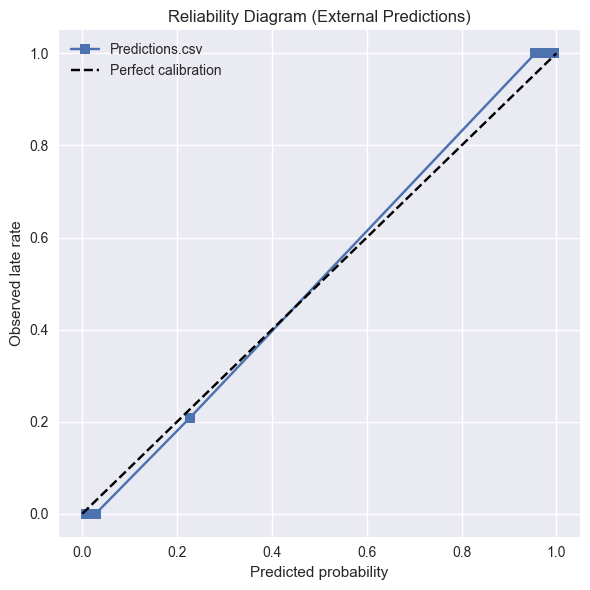

Brier score: 0.0008


In [13]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import numpy as np
import matplotlib.pyplot as plt

y = y_valid_ext
p = p_valid_ext

p = np.clip(p, 1e-6, 1 - 1e-6)

prob_true, prob_pred = calibration_curve(y, p, n_bins=10, strategy='quantile')

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, "s-", label="Predictions.csv")
plt.plot([0,1], [0,1], "k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed late rate")
plt.title("Reliability Diagram (External Predictions)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

brier = brier_score_loss(y, p)
print(f"Brier score: {brier:.4f}")




Slice performance by ship_mode:


,group,n,PR_AUC,ROC_AUC,F1@0.5,late_rate
2,road,408,1.0,1.0,1.0,0.507353
1,rail,37,1.0,1.0,1.0,0.486486
0,air,129,1.0,1.0,1.0,0.356589
3,sea,161,1.0,1.0,1.0,0.677019


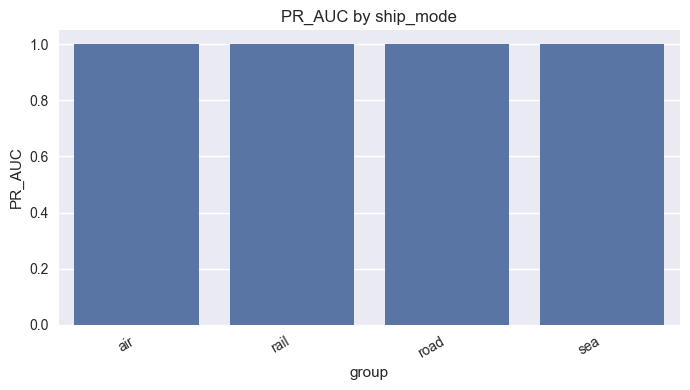


Slice performance by country:


,group,n,PR_AUC,ROC_AUC,F1@0.5,late_rate
2,DE,35,1.0,1.0,1.0,0.514286
0,CN,73,1.0,1.0,1.0,0.616438
1,CZ,72,1.0,1.0,1.0,0.513889
3,FR,26,1.0,1.0,1.0,0.576923
4,IN,107,1.0,1.0,1.0,0.504673
5,IT,116,1.0,1.0,1.0,0.508621
6,NL,94,1.0,1.0,1.0,0.436170
7,PL,144,1.0,1.0,1.0,0.458333
8,UK,29,1.0,1.0,1.0,0.724138
9,US,39,1.0,1.0,1.0,0.615385


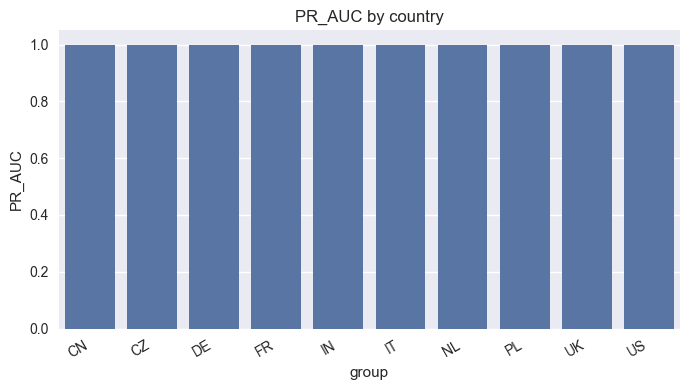


Slice performance by distance_bucket:


,group,n,PR_AUC,ROC_AUC,F1@0.5,late_rate
0,<=500km,141,1.0,1.0,1.0,0.404255
1,500-2000km,594,1.0,1.0,1.0,0.543771


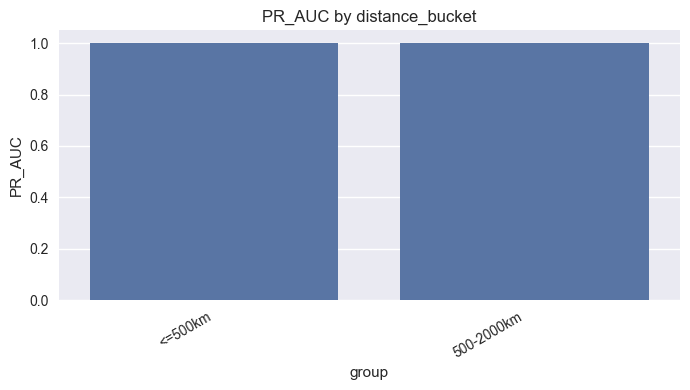

In [15]:
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
import pandas as pd

def slice_metrics(meta_df, y_arr, p_arr, group_name, min_size=10):
    results = []
    for g, idx in meta_df.groupby(group_name, observed=True).groups.items():
        if len(idx) < min_size:
            continue
        y_g = y_arr[idx]
        p_g = p_arr[idx]
        try:
            pr_auc = average_precision_score(y_g, p_g)
            roc_auc = roc_auc_score(y_g, p_g)
        except ValueError:
            pr_auc, roc_auc = None, None
        f1 = f1_score(y_g, (p_g >= 0.5).astype(int))
        results.append({
            "group": g, "n": len(y_g),
            "PR_AUC": pr_auc, "ROC_AUC": roc_auc, "F1@0.5": f1,
            "late_rate": y_g.mean()
        })
    return pd.DataFrame(results)

def show_slice(meta_df, y_arr, p_arr, group_name):
    print(f"\nSlice performance by {group_name}:")
    res = slice_metrics(meta_df, y_arr, p_arr, group_name)
    if res.empty:
        print(f"No valid groups for {group_name}")
        return
    display(res.sort_values("PR_AUC", ascending=False))

    plot_df = res.dropna(subset=["PR_AUC"])
    if not plot_df.empty:
        plt.figure(figsize=(7,4))
        sns.barplot(data=plot_df, x="group", y="PR_AUC", order=plot_df["group"])
        plt.title(f"PR_AUC by {group_name}")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()

meta_ext = merged[['ship_mode','supplier_id','distance_km']].copy()
if 'country' in sup.columns:
    meta_ext = meta_ext.merge(sup[['supplier_id','country']], on='supplier_id', how='left')
if 'distance_km' in meta_ext.columns:
    bins = [-np.inf, 500, 2000, 5000, np.inf]
    labels = ['<=500km','500-2000km','2000-5000km','>5000km']
    meta_ext['distance_bucket'] = pd.cut(meta_ext['distance_km'], bins=bins, labels=labels)

if 'ship_mode' in meta_ext.columns:
    show_slice(meta_ext, y_valid_ext, p_valid_ext, 'ship_mode')

if 'country' in meta_ext.columns:
    show_slice(meta_ext, y_valid_ext, p_valid_ext, 'country')

if 'distance_bucket' in meta_ext.columns:
    show_slice(meta_ext, y_valid_ext, p_valid_ext, 'distance_bucket')


In [16]:
from sklearn.metrics import confusion_matrix

capacity_pct = 0.15
k = max(1, int(np.ceil(capacity_pct * len(p_valid_ext))))
sorted_scores = np.sort(p_valid_ext)[::-1]
thr_15 = sorted_scores[k-1] if k-1 < len(sorted_scores) else sorted_scores[-1]

yhat_15 = (p_valid_ext >= thr_15).astype(int)

cm = confusion_matrix(y_valid_ext, yhat_15)
tn, fp, fn, tp = cm.ravel()

print(f"Chosen business threshold = top {int(capacity_pct*100)}% (≈ {k} orders)")
print(f"Probability cutoff: {thr_15:.4f}")
print("Confusion Matrix (TN, FP, FN, TP):", (tn, fp, fn, tp))
print(f"Precision: {tp / (tp+fp+1e-9):.3f}")
print(f"Recall:    {tp / (tp+fn+1e-9):.3f}")
print(f"Late rate in high-risk bucket: {y_valid_ext[yhat_15==1].mean():.3f}")
print(f"Late rate in low-risk bucket:  {y_valid_ext[yhat_15==0].mean():.3f}")


Chosen business threshold = top 15% (≈ 111 orders)
Probability cutoff: 0.9867
Confusion Matrix (TN, FP, FN, TP): (np.int64(355), np.int64(0), np.int64(263), np.int64(117))
Precision: 1.000
Recall:    0.308
Late rate in high-risk bucket: 1.000
Late rate in low-risk bucket:  0.426
